# Simulation of model

In [130]:
import numpy as np
import pandas as pd
from sympy import symbols, solve, Eq
from scipy.optimize import fmin, minimize
#import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

pd.options.mode.chained_assignment = None

## Setup
draw n random values for sigma

define $\pi$, $\phi$ and $\alpha$

count    10000.000000
mean       843.030570
std        445.156900
min        131.396809
25%        534.338229
50%        746.738691
75%       1044.745299
max       5053.075095
dtype: float64


<AxesSubplot:ylabel='Density'>

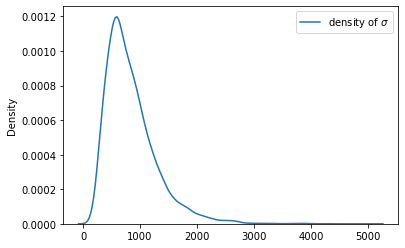

In [131]:
# number of random sigmas
np.random.seed(111)
n = 10000
# mean and sd of normal distribution 
m, s = 2,0.5
sigma = np.random.lognormal(mean=m, sigma=s, size=n) # takes values for normal distribution as inputs
# make to list
sigma = sigma.tolist()
sigma = [x * 100 for x in sigma] # rescaling sigma
print(pd.Series(sigma).describe())
# distribution
sns.kdeplot(sigma, label=r'density of $\sigma$')
plt.legend()


pi = 250
phi = 50
alpha = 0.8


## Fine Schedule

([<matplotlib.axis.XTick at 0x285059d0dc0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

([<matplotlib.axis.YTick at 0x2857ee76f10>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

Text(1, 0, 'x')

Text(0, 1, '$\\phi$')

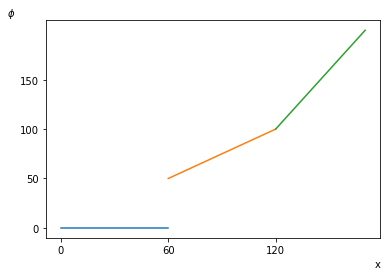

In [132]:
x0, y0 = [0,60], [0,0]
x1, y1 = [60, 120], [50,100]
x2, y2 = [120,170], [100,200]
plt.plot(x0, y0)
plt.plot(x1,y1,x2, y2)
plt.xticks([0,60,120])
plt.yticks([0,50,100,150])
plt.xlabel('x', loc = 'right')
plt.ylabel(r'$\phi$', loc = 'top', rotation = 'horizontal')
plt.show()

## Cost functions
fixing cost function $C(x,\sigma) = \frac{\sigma}{\alpha} (\frac{x}{\sigma})^{-\alpha}$

Text(0.5, 0, 'x')

Text(0, 0.5, 'C(x)')

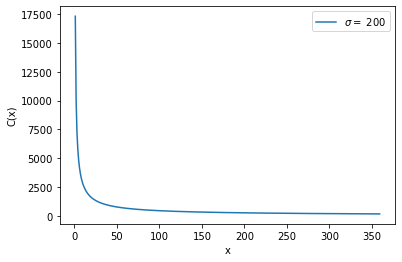

In [133]:
def C(x, sigma, alpha):
    first = sigma / alpha
    second = x / sigma
    power = -alpha
    return  first * (second**power)


# plot for fixed sigma
sigma_fix = 200
x = np.arange(1,360,1)  
plt.plot(x,C(x,sigma_fix, alpha), label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('C(x)')

Cost function $K(x,\sigma) = (\pi + \phi)x + C(x, \sigma)$ with x, $\sigma$, $\pi$ and $\phi$ as inputs, $\phi = 50$ Rs if $x > 60$

Text(0.5, 0, 'x')

Text(0, 0.5, 'K(x)')

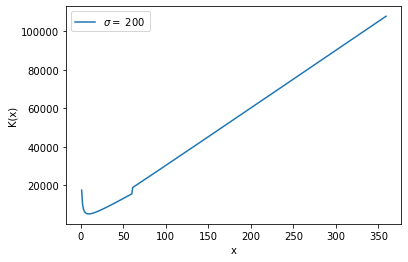

In [134]:
def K(x,sigma, pi, phi, alpha):
    if x <= 60:
        exp =  (pi) * x + C(x, sigma, alpha)
    elif x > 60:  
        exp = (pi + phi) * x + C(x, sigma, alpha)  
    return exp


# plot K with fixed sigma 
x = np.arange(1,360,1)
Ks = [K(x,sigma = sigma_fix, pi = pi, phi = phi, alpha = alpha) for x in x]  
plt.plot(x,Ks, label = f'$\sigma = $ {sigma_fix}')
plt.legend()
plt.xlabel('x')
plt.ylabel('K(x)')  

optimal x as a function of $\sigma$ : $x = \sigma (\pi + \phi)^{-1/(1+\alpha)}$

xopts: count    10000.000000
mean        39.233263
std         20.716874
min          6.114992
25%         24.867227
50%         34.751997
75%         48.620736
max        235.161845
dtype: float64
xopts2: count    10000.000000
mean        35.453968
std         18.721241
min          5.525942
25%         22.471795
50%         31.404377
75%         43.937157
max        212.508976
dtype: float64


Text(0.5, 0, '$\\sigma$')

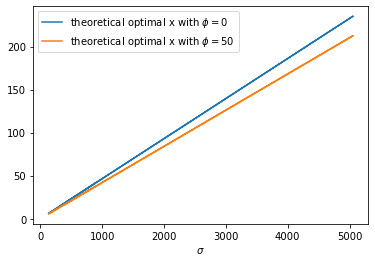

In [135]:
# optimal theoretical x
def xopt(sigma, pi=pi, phi=phi, alpha = alpha):
    x = sigma * (pi + phi)**(-1/(1+alpha))
    return x

xopts = [xopt(s, phi=0) for s in sigma]

# optimal theoretical x with phi
xopts2 = [xopt(s, phi=phi) for s in sigma]

print('xopts:',pd.Series(xopts).describe())
print('xopts2:',pd.Series(xopts2).describe())

plt.plot(sigma, xopts, label =r'theoretical optimal x with $\phi = 0$')
plt.plot(sigma, xopts2, label =f'theoretical optimal x with $\phi = {phi}$')

plt.xlabel(r'$\sigma$')
plt.legend()


### Fine schedule tradeoff
THIS WAS WRONG. CORRECT EQUATION IS:

$\pi*60 + \frac{\sigma}{\alpha} (\frac{60}{\sigma})^{-\alpha} \leq (\pi + \phi)^{\alpha/(1+\alpha)} (\sigma + \frac{\sigma}{\alpha})$

Text(0.5, 0, '$\\sigma$')

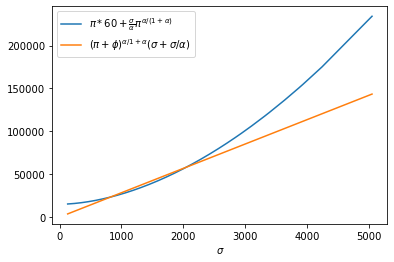

In [136]:
left = [K(60,s,pi,phi,alpha)  for s in sigma]
right = [(pi + phi)**(alpha/(1+alpha)) * (s + s/alpha) for s in sigma]
tradeoff = pd.DataFrame({'sigma':sigma, 'left':left, 'right':right}).sort_values('sigma')

plt.plot(tradeoff.sigma, tradeoff.left, label = r'$\pi*60 + \frac{\sigma}{\alpha} \pi^{\alpha/(1+\alpha)}$')
plt.plot(tradeoff.sigma, tradeoff.right, label = r'$(\pi + \phi)^{\alpha/1+\alpha} ( \sigma + \sigma / \alpha) $')
plt.xlabel(r'$\sigma$')
#plt.ylim(0,10000)
#plt.xlim(100,800)
plt.legend()

solve for $\sigma$ where equality holds

In [137]:
## there are two solutions, take higher one (need to think a bit more about this)
s = symbols('s')
exp = K(60,s,pi,phi,alpha) - (pi + phi)**(alpha/(1+alpha)) * (s + s/alpha)
sigma_bar = solve(exp)
if len(sigma_bar) > 0:
    print('Cutoff sigma is', f'{sigma_bar[1]:.2f}')
else: print('lines do not intersect')
print(sigma_bar)
sigma_bar = sigma_bar[1]

Cutoff sigma is 2048.74
[822.536079877515, 2048.73569863144]


therotical x combining both.. Let's call this D
here we should use the equation solving for sigma bar (at the very bottom) which will give us a sigma below which we take xopt and above which we take xopts2. create a variable s.t. x = xopts if $\sigma<\bar{\sigma}$ and $x = xopts2$ otherwise. 

solve for $\sigma$ where x = 60

In [138]:
s = symbols('s')
exp = xopt(s, pi=pi, phi=0, alpha = alpha) - 60
sigma_sixty = solve(exp)
if len(sigma_sixty) > 0:
    print(' sigma of duration 60 is', f'{sigma_sixty[0]:.2f}')
else: print('lines do not intersect')

sigma_sixty = sigma_sixty[0]

 sigma of duration 60 is 1289.26


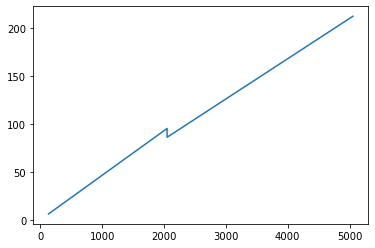

In [139]:
combined = [xopt(s, phi=0) if s <= sigma_bar else xopt(s, phi=phi) for s in sigma]
combined_sorted = [xopt(s, phi=0) if s <= sigma_bar else xopt(s, phi=phi) for s in sorted(sigma)]

plt.plot(sorted(sigma), combined_sorted)


This is not entirely correct because it doesnt include bunching. To include bunching: recall that a firm will bunch (meaning choose x = 60) if the cost of not bunching at xopts2 (paying phi) is higher than the cost of bunching (choosing x=60 and not paying phi). This will be a range between sigma at xopts=60.
Step 1: solve for sigma from xopts = 60 (phi = 0)

Step 2: solve for sigma indifference as above

Step 3: replace x = 60 for all sigma between the two sigmas

Step 4: replace x = xopts for the sigmas below sigma in step 1, and x = xopts2 for the sigmas above sigma indifference in step 2. 

Let's do this and plot D against the x's we're getting from the minimizations.

1289.25891776314 2048.73569863144


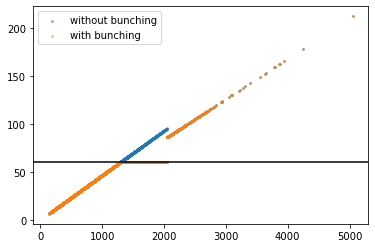

In [140]:
dfx = pd.DataFrame(list(zip(sigma, xopts, xopts2, combined)), columns=['sigma', 'xopts', 'xopts2', 'combined'])

# find sigma for x close to 60 but below?? 
# Dana: I think here we should solve for the sigma that corresponds to x = 60 from the expression of xopts. this should be an exact relationshop that can be solved from the theoretical equation.
s = symbols('s')
exp = 60 - xopt(s,phi=0) #this needs to be at phi = 0
s60 = solve(exp)[0]
step1 = s60

# this is the same as sigma_sixty ##

#step1 = dfx.loc[dfx['xopts'][dfx.xopts <= 60].sub(60).abs().idxmin(),'sigma']
#print(dfx.loc[dfx['xopts'].sub(60).abs().idxmin(),])

# step 2: sigma_bar
print(step1, sigma_bar)

# step 3
dfx['combined'] = dfx.apply(lambda row: 60 if (row.sigma <= sigma_bar and row.sigma > step1) else row.combined, axis = 1)

# step 4
dfx['combined'] = dfx.apply(lambda row: row.xopts if row.sigma < step1 else (row.xopts2 if row.sigma > sigma_bar else row.combined), axis = 1)


plt.scatter(sigma, combined,marker = 'o', label='without bunching', alpha=.5, s = 3)
plt.scatter(dfx.sigma, dfx.combined, marker = 'o', label='with bunching', alpha=.5, s= 3)
plt.axhline(60, color ='black')
plt.legend()


### Minimization
find the minimum x of K() for all sigmas

In [141]:
'''
xstar = {}
for s in sigma:
    #if s < 150:
    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)
    x = fmin(K,x0 = 10, args=(s,pi, phi, alpha), disp=False) 
    #else: x[0] = np.nan    
    if x < 0:
        raise ValueError('x negative')
    xstar[s] = x[0] # output of fmin is a list, access first element

### DANA
'''
xstar = {}
for s in sigma:
    #if s < 150:
    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)
    #x = fmin(K, x0 = 5, args=(s,pi,phi,alpha))
    x = minimize(K, x0 = 10, args=(s,pi, phi, alpha), method = 'powell', # Nelder-Mead
                 options={'xatol': 1e-8, 'disp': False}) 
    #else: x[0] = np.nan    
    #if x < 0:
     #   raise ValueError('x negative')
    xstar[s] = x['x'] # output of minimize is an array?? 

  

"\nxstar = {}\nfor s in sigma:\n    #if s < 150:\n    x_start = xopt(s, pi=pi, phi=phi, alpha=alpha)\n    x = fmin(K,x0 = 10, args=(s,pi, phi, alpha), disp=False) \n    #else: x[0] = np.nan    \n    if x < 0:\n        raise ValueError('x negative')\n    xstar[s] = x[0] # output of fmin is a list, access first element\n\n### DANA\n"

<ipython-input-141-f60c4b2195b7>:19: OptimizeWarning: Unknown solver options: xatol
  x = minimize(K, x0 = 10, args=(s,pi, phi, alpha), method = 'powell', # Nelder-Mead
<ipython-input-133-bcbd6a1e3800>:5: RuntimeWarning: invalid value encountered in power
  return  first * (second**power)


now put all all in a dataframe and calculate the costs for the optimal x's

In [142]:
df = pd.DataFrame.from_dict(xstar, orient='index', columns=['xstar'])
df = df.reset_index()
df = df.rename(columns={'index':'sigma'})


# calculate fixing cost C
df['fixing_cost'] = df.apply(lambda row: C(row.sigma,row.xstar, alpha=alpha), axis=1)
# calculate cost K
df['K'] = df.apply(lambda row: K(row.xstar, row.sigma, pi = pi, phi = phi, alpha=alpha), axis=1)
# cost K if bunching
df['KBunch'] = df.apply(lambda row: K(60, row.sigma, pi = pi, phi = phi, alpha=alpha), axis=1)


#print(df.xstar.describe())
#df.sort_values('sigma')
#print(df)

So it seems that the algorithm is not always picking the right solutions. To be more precise it doesn't always pick the corner solution at 60 when it should (compare the densities and the binned graphs of the two xs below). 

What i did is compare the K at the optimal solution picked by the algorithm to K at bunching to check if it's choosing the correct solution (basically for sigma < sigma bar=2048). Have a look at KBunch vs K around the value of sigma bar to see what I mean.

The algorithm seems to be sensitive to the initial values. Somehow x=10 gave me the (almost) correct solutions. 

Can we try to improve on this or at least understand why? Ultimately we actually don't need the minimization there, we can do it ourselves (i.e. just keep x theoritcal) but we should understand why this is happening.

## Plots
compare the theoretical x and the x calculated from minimization and their density

should we use here the theoretical one with bunching?

<AxesSubplot:xlabel='xstar', ylabel='Density'>

<AxesSubplot:xlabel='xstar', ylabel='Density'>

(array([1.300e+01, 4.600e+01, 9.100e+01, 1.980e+02, 2.570e+02, 3.470e+02,
        3.520e+02, 4.520e+02, 4.540e+02, 4.830e+02, 5.560e+02, 5.330e+02,
        4.900e+02, 4.330e+02, 4.340e+02, 3.980e+02, 3.900e+02, 3.710e+02,
        3.410e+02, 3.380e+02, 2.950e+02, 2.660e+02, 2.410e+02, 2.190e+02,
        1.960e+02, 1.980e+02, 1.560e+02, 1.243e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.800e+01,
        2.100e+01, 1.300e+01, 1.900e+01, 1.800e+01, 9.000e+00, 1.200e+01,
        6.000e+00, 1.400e+01, 8.000e+00, 6.000e+00, 1.000e+01, 7.000e+00,
        1.100e+01, 5.000e+00, 5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+0

(array([1.300e+01, 4.600e+01, 9.100e+01, 1.980e+02, 2.570e+02, 3.470e+02,
        3.520e+02, 4.520e+02, 4.540e+02, 4.830e+02, 5.560e+02, 5.330e+02,
        4.900e+02, 4.330e+02, 4.340e+02, 3.980e+02, 3.900e+02, 3.710e+02,
        3.410e+02, 3.380e+02, 2.950e+02, 2.660e+02, 2.410e+02, 2.190e+02,
        1.960e+02, 1.980e+02, 1.560e+02, 1.232e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.900e+01,
        2.100e+01, 1.300e+01, 1.900e+01, 1.800e+01, 9.000e+00, 1.200e+01,
        6.000e+00, 1.400e+01, 8.000e+00, 6.000e+00, 1.000e+01, 7.000e+00,
        1.100e+01, 5.000e+00, 5.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 2.000e+0

(45.0, 90.0)

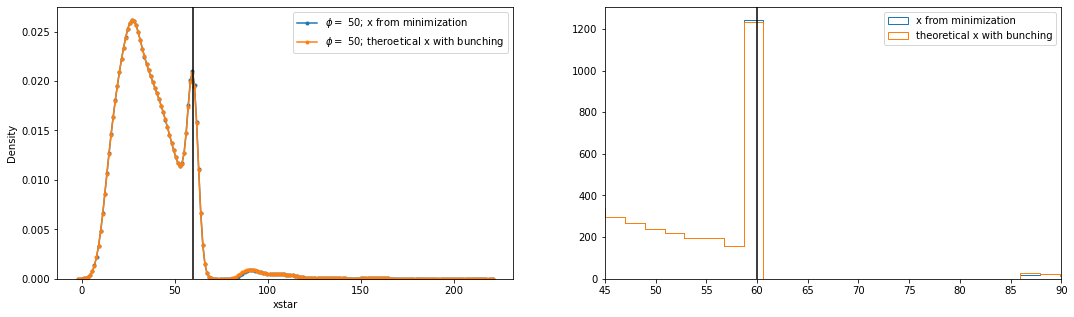

In [143]:
fig, axs = plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(df.xstar, marker='o', markersize=3, label = f'$\phi =$ {phi}; x from minimization', ax=axs[0]) 
sns.kdeplot(dfx.combined, marker='o', markersize=3, label = f'$\phi =$ {phi}; theroetical x with bunching', ax=axs[0]) 
axs[0].axvline(60, color = 'black')
axs[0].legend()
## Can we also plot the histograms of the xstar and xopt like the graph I showed you with the real data? e.g. number of observations in each bin (3 min)
n_bins = round(df.xstar.max()/2)
axs[1].hist(df.xstar, histtype='step', bins = n_bins, label='x from minimization')
axs[1].hist(dfx.combined, histtype='step', bins =n_bins, label='theoretical x with bunching')
axs[1].axvline(60, color = 'black')
axs[1].legend()
plt.xlim(45,90)
plt.show()

# Something is not exactly right here with the theoretical x with bunching. 
#There should be a missing mass just above 60 and more bunching at 60. Maybe we're not replacing but adding values?


Text(0.5, 0, '$\\sigma$')

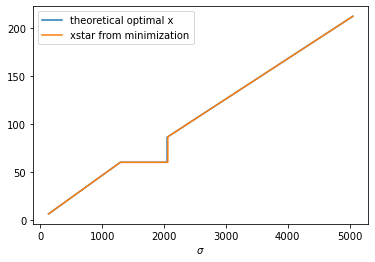

In [144]:
df_order = df.sort_values('sigma')
dfx_order = dfx.sort_values('sigma')
plt.plot(dfx_order.sigma, dfx_order.combined, label=r'theoretical optimal x')
plt.plot(df_order.sigma, df_order.xstar, label='xstar from minimization' )
#plt.xlim(100,800)
plt.xlabel(r'$\sigma$')
plt.legend()


plot the optimal $x(\sigma)$ and the functions $C(x,\sigma)$ and $K(x,\sigma)$

Text(0.5, 1.0, 'xstar')

Text(0.5, 1.0, 'fixing cost C')

Text(0.5, 1.0, 'K')

Text(1, 0, '$\\sigma$')

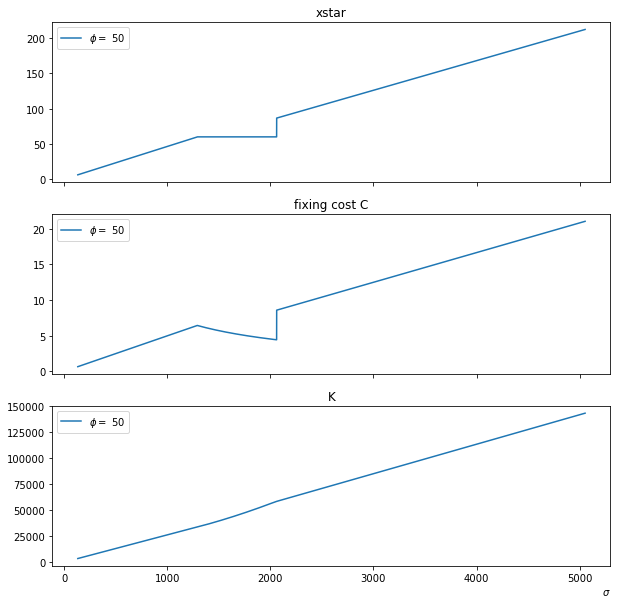

In [145]:
# first sort df in ascending order for sigmas
df_order = df.sort_values('sigma')

fig, axs = plt.subplots(3,1,figsize=(10,10), sharex=True)
axs[0].plot(df_order.sigma, df_order.xstar, label=f'$\phi =$ {phi}')
axs[0].set_title('xstar')
axs[1].plot(df_order.sigma, df_order.fixing_cost, label=f'$\phi =$ {phi}')
axs[1].set_title('fixing cost C')
axs[2].plot(df_order.sigma, df_order.K, label=f'$\phi =$ {phi}')
axs[2].set_title('K')
axs[2].set_xlabel(r'$\sigma$', loc='right')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.show()

## Indifference condition - Visualization  

{c: 799.698648092585}


<ipython-input-133-bcbd6a1e3800>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return  first * (second**power)


<ipython-input-133-bcbd6a1e3800>:5: RuntimeWarning: divide by zero encountered in double_scalars
  return  first * (second**power)


(0.0, 160.0)

(-10.0, 350.0)

Text(1, 0, 'x')

Text(0, 1, '$L(\\pi, \\phi, x)$')

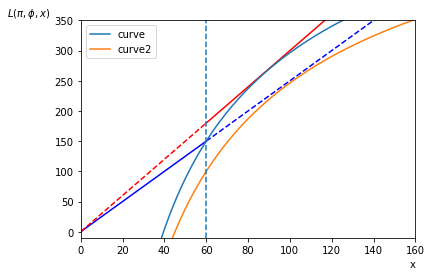

In [146]:
def curve(x, s,a, c=65):
    y = c-C(x,sigma=s, alpha=a)
    return y

  
s = 185
a = .5

# I rescale it here because it would be very steep otherwise
slope1 = pi /100
slope2 = (pi + phi) /100

c=symbols('c')
exp = Eq(60*slope1 - curve(60, s=s, a=a,c=c),0)
res = solve([exp],(c))
print(res)

# lines
plt.plot([0,60],[0,60 * slope1], color = 'blue')
plt.plot([60,160],[60*slope1, 160*slope1], linestyle='dashed',color = 'blue')
plt.plot([0,60],[0,60 * slope2], linestyle='dashed',color = 'red')
plt.plot([60,160],[60*slope2, 160*slope2], color = 'red')
#curve
x = np.linspace(0,160,160)
y = [curve(x,s=s, a=a, c=res[c]) for x in x]
plt.plot(x,y, label='curve')
y2 = [curve(x,s=s, a=a, c=res[c]-50) for x in x]
plt.plot(x,y2, label='curve2')
plt.axvline(60, linestyle='dashed')
#plt.axvline(res[x], linestyle='dashed')
plt.xlim(0,160)
plt.ylim(-10,350)
plt.xlabel('x', loc='right')
plt.ylabel(r'$L(\pi, \phi, x)$', loc='top', rotation='horizontal')
plt.legend()
plt.show()

# Bunching Estimation

In [147]:
# define binsize
bsize = 2

# define maximum of xstar
xmax = 90

# define bins
nbins = int(xmax/bsize +1)
bins = [(x) * 3 for x in range(nbins)]

# define excluded region (number of bins)
ex_reg = 5

# define z_upper and z_lower
z_upper = 60
z_lower = 60 - ex_reg * bsize


# count how many observations in each bin
nobs = df.xstar.groupby(pd.cut(df.xstar, bins)).count()


# put it in a df
count = pd.DataFrame(list(zip([(x,x+3) for x in bins],nobs)), columns=['bin', 'nobs'])

count['duration_min'] = count.apply(lambda row: row.bin[1], axis = 1)
count.head()


,bin,nobs,duration_min
0,"(0, 3)",0,3
1,"(3, 6)",0,6
2,"(6, 9)",28,9
3,"(9, 12)",123,12
4,"(12, 15)",350,15


In [148]:
# define degree of polynomial
dgr = 9 

# create polynomials
for i in range(2,dgr+1):
    n = 'duration_min' + str(i)
    count[n] = count.duration_min ** i

# create dummy var
count['b60'] = count.apply(lambda row: (row['duration_min'] < z_upper) & (row['duration_min'] >= z_lower), axis = 1).astype(int)

# focus on duration less than 90
count_reg = count.loc[count.duration_min < 90,:]

#print(count_reg.head())

# define x and y 
coefs = ['duration_min']
[coefs.append('duration_min' + str(i)) for i in range(2,dgr+1)] 
coefs.append('b60')
X = count_reg.loc[:,coefs]

y = count_reg.nobs
# regression
X = sm.add_constant(X)
model = sm.OLS(y , X).fit()

display(model.summary())


count_reg['zeros'] = 0
coefs_new = coefs[:-1]
coefs_new.append('zeros')
X_ = count_reg.loc[:,coefs_new]
X_ = sm.add_constant(X_)

y_pred = model.predict(X_)

count_reg['ypred'] = y_pred

display(count_reg.loc[:,['nobs', 'ypred']])

# excess mass
x60 = np.sum(count_reg.loc[(count_reg['duration_min'] < z_upper) & (count_reg['duration_min'] >= z_lower), 'ypred'])
y60 = np.sum(count_reg.loc[(count_reg['duration_min'] < z_upper) & (count_reg['duration_min'] >= z_lower), 'nobs'])
delta_x = (y60-x60) / (y60/ex_reg)
print(x60,y60, 'delta x:', delta_x)

[None, None, None, None, None, None, None, None]

C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     8.975
Date:                Tue, 24 Aug 2021   Prob (F-statistic):           7.70e-05
Time:                        17:09:07   Log-Likelihood:                -195.34
No. Observations:                  29   AIC:                             402.7
Df Residuals:                      23   BIC:                             410.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.000      0.459      0.651      -0.001       0.001
duration_min      0.0015      0.003      0.460      0.650      -0.005       0.008
duration_min2     0.0222      0.048      0.462      0.649      -0.077       0.122
duration_min3     0.1288      0.276      0.467      0.645      -0.442       0.699
duration_min4     0.0056      0.034      0.165      0.870      -0.064       0.075
duration_min5    -0.0009      0.002     -0.544      0.591      -0.004       0.002
duration_min6  3.228e-05   4.07e-05      0.793      0.436   -5.19e-05       0.000
duration_min7 -5.323e-07    5.5e-07     -0.967      0.344   -1.67e-06    6.06e-07
duration_min8  4.213e-09   3.86e-09      1.092      0.286   -3.76e-09    1.22e-08
duration_min9 -1.299e-11    1.1e-11     -1.185      0.248   -3.57e-11    9.69e-12
b60            3.952e-05   8.63e-05      0.458      0.651      -0.000       0.000
==============================================================================
Omnibus:                       46.978   Durbin-Watson:                   2.536
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              254.492
Skew:                           3.107   Prob(JB):                     5.47e-56
Kurtosis:                      16.115   Cond. No.                     2.35e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+18. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\paula\anaconda3\envs\dehli\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,nobs,ypred
0,0,3.938232
1,0,30.271919
2,28,94.391276
3,123,198.603397
4,350,332.251976
5,482,475.982059
6,607,607.587800
7,695,707.624261
8,839,763.614827
9,786,772.243521


1404.9338662455991 1005 delta x: -1.9897207275900455


solve for $\alpha$

In [149]:
a = symbols('a')
exp = (1 + delta_x/60) * (((pi + phi)/phi)**(a/(1+a)) * (a+1) - (1 + delta_x/60)**a) - a * ((pi + phi)/phi)
res = solve(exp)

print(res)

NotImplementedError: multiple generators [a, 1000000000000000**a, 6**(a/(a + 1)), 966837987873499**a]
No algorithms are implemented to solve equation 966837987873499*6**(a/(a + 1))*(a + 1)/1000000000000000 - 966837987873499*(966837987873499/1000000000000000)**a/1000000000000000 - 6*a